# first just make two models that works on mnist. One fully connected an then one conv

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import math
import time

#tds
import torchvision

#git
#from __future__ import print_function
#import argparse
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.1
momentum = 0.5
log_interval = 10

#nj stuff i dont get
#random_seed = 1
#torch.backends.cudnn.enabled = False
#torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, 
                              download=True,
                              transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
                              batch_size=batch_size_train, 
                                shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)
print('loaded the mnist data')

loaded the mnist data


In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader

def get_data_loaders(train_batch_size, test_batch_size, resize=0):
    if resize == 0:
        train_loader = torch.utils.data.DataLoader(
          torchvision.datasets.MNIST('data/', train=True, 
                                  download=True,
                                  transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                                 ])),
                                  batch_size=batch_size_train, 
                                    shuffle=True)

        test_loader = torch.utils.data.DataLoader(
          torchvision.datasets.MNIST('data/', train=False, download=True,
                                 transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                                 ])),
                                  batch_size=batch_size_test, shuffle=True)

    else:
        mnist = MNIST('data/', download=False, train=True).train_data.float()

        data_transform = Compose([ Resize((224, 224)),ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])

        train_loader = DataLoader(MNIST('data/', download=True, transform=data_transform, train=True),
                                  batch_size=train_batch_size, shuffle=True)

        test_loader = DataLoader(MNIST('data/', download=False, transform=data_transform, train=False),
                                batch_size=test_batch_size, shuffle=False)
    
    print('loaded the mnist data')
    return train_loader, test_loader


In [4]:
train_loader, test_loader = get_data_loaders(batch_size_train, batch_size_test, resize=1)

/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


loaded the mnist data


In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 224, 224])

In [6]:
example_data[0]

tensor([[[-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240],
         [-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240],
         [-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240],
         ...,
         [-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240],
         [-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240],
         [-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240]]])

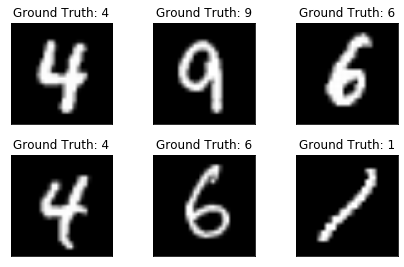

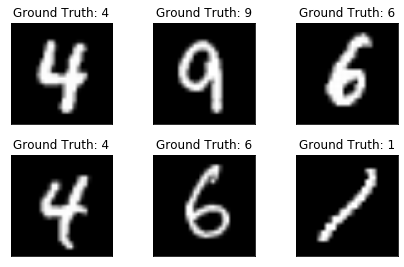

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [8]:
# counts trainable weights in a model
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride = 1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, stride = 1)
        self.conv2_drop = nn.Dropout2d()
        self.flatten_nbr = 53*53*10 # 4*4*10
        self.fc1 = nn.Linear(self.flatten_nbr, 10)
        #self.fc2 = nn.Linear(256, 10)

    def forward(self, x):    
        
        #print(x.shape) # torch.Size([64, 1, 224, 224])
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape) # torch.Size([64, 10, 55, 55])
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape) # torch.Size([64, 10, 25, 25])
        x = x.view(-1, self.flatten_nbr)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        # x = F.dropout(x, training=self.training)
        #print(x.shape)
        # x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x, dim = 1)

print(Net())
count_params(Net())

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=28090, out_features=10, bias=True)
)


283680

In [33]:
# Base for ResNet
# Vill ha bilder av storlek 224x224
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
    # dilation=1, groups=1, bias=True, padding_mode='zeros')
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        """
        planes is the number of filters we want
        inplanes can differ from planes as we can get inputs from multiple places
        """
        super(BasicBlock, self).__init__()
        
        norm_layer = nn.BatchNorm2d
        groups=1,
        base_width=64
        dilation = 1
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    
class ResNet(nn.Module):
    # ResNet(BasicBlock, [2, 2, 2, 2])
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        
        self.groups = 1
        self.base_width = 64
        # Första filtret för ResNet "börjar"
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # Slutfas
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # What is this???
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = 1
        dilate=False
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion  # block expansion = 1 for basic block
        
        # Loop unnecessary as blocks = 2
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

#ResNet(BasicBlock, [2, 2, 2, 2])
print(ResNet(BasicBlock, [1,1,1,1]))

count_params(ResNet(BasicBlock, [1, 1,1,1]))

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

4904650

In [40]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        inputsize = int(example_data.shape[-1] / 1) ** 2
        self.l1 = nn.Linear(inputsize, 64)
        self.l4 = nn.Linear(64, 10)

    def forward(self, x):
        #x = F.avg_pool2d(x, 2)
        x = x.view(x.shape[0],-1)
        x = torch.relu(self.l1(x))
        x = self.l4(x)
        return F.log_softmax(x, dim = 1)

print(MLP())
count_params(MLP())

MLP(
  (l1): Linear(in_features=784, out_features=64, bias=True)
  (l4): Linear(in_features=64, out_features=10, bias=True)
)


50890

In [41]:
# not feasible for digits
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride = 1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, stride = 1)
        self.conv2_drop = nn.Dropout2d()
        self.flatten_nbr = 4*4*20
        self.fc1 = nn.Linear(self.flatten_nbr, 256)  # 4*4*20
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.flatten_nbr)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

print(CNN())
count_params(CNN())

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


86826

In [13]:
outputs.size()

NameError: name 'outputs' is not defined

In [26]:
criterion = nn.CrossEntropyLoss()       # what is this

network = ResNet(BasicBlock, [1, 1,1,1])

dataiter = iter(train_loader)
images, labels = dataiter.next()
outputs = network(images)

# what is default values for lr and momentum
# optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      # momentum=momentum)
    
# optimizer = optim.SGD(network.parameters(), lr=0.1)
# optimizer = optim.RMSprop(network.parameters())
optimizer = optim.Adam(network.parameters())

In [27]:
# tog typ en kvart
t0 = time.perf_counter()
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training it took ', (time.perf_counter() - t0)/60, ' minutes to train')

[1,   200] loss: 0.335
[1,   400] loss: 0.091
[1,   600] loss: 0.068
[1,   800] loss: 0.063
Finished Training it took  173.5382124814166  minutes to train


In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
   
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 99.010000 %


In [ ]:
med net lr = 0.01
[1,   200] loss: 2.228
[1,   400] loss: 1.623
[1,   600] loss: 1.265
[1,   800] loss: 1.060
Finished Training it took  9.284094596350041  minutes to train
accuracy of the network on the 10000 test images: 71 %
82 % med lr = 0.1

30 secunder och 84% med Net
45 secunder och 94% med större Net

Med 224 bilder
[1,   200] loss: 0.764
[1,   400] loss: 0.477
[1,   600] loss: 0.430
[1,   800] loss: 0.412
Finished Training it took  37.939007360069084  minutes to train
Accuracy of the network on the 10000 test images: 90 %
    
Med ResNet(BasicBlock, [1, 1,1,1])
[1,   200] loss: 0.335
[1,   400] loss: 0.091
[1,   600] loss: 0.068
[1,   800] loss: 0.063
Finished Training it took  173.5382124814166  minutes to train
Accuracy of the network on the 10000 test images: 99.01 %

In [52]:
555/60

9.25

In [37]:
for _ in range(1, 2):
    print('hej')

hej


25*25

In [51]:
25*25*10*64

400000